# 蠟燭線回測
### 初始資料拿取

In [1]:
import numpy as np
import pandas as pd
import talib
from talib import MACD
from scipy.signal import argrelextrema
import matplotlib as plt

%matplotlib inline

In [2]:
df = pd.read_csv('TXF\TXF.txt', sep=",")
df['DateTime'] = df.Date + ' ' + df.Time

In [3]:
prices = df.iloc[2000:2500,:].copy()

In [4]:
def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['Close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []

    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['High'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['Low'].idxmin())  

    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
#     max_min = pd.concat([maxima, minima]).sort_index()
    maxima.index.name = 'date'
    minima.index.name = 'date'
    
    maxima = maxima.reset_index()
    maxima = maxima[~maxima.date.duplicated()]
    p = prices.reset_index()   
    maxima['day_num'] = p[p['index'].isin(maxima.date)].index.values
    maxima = maxima.set_index('day_num')['High']
    
    minima = minima.reset_index()
    minima = minima[~minima.date.duplicated()]  
    minima['day_num'] = p[p['index'].isin(minima.date)].index.values
    minima = minima.set_index('day_num')['Low']
    
    return maxima, minima

In [126]:
smoothing = 5
window = 20

maxima, minima = get_max_min(prices, smoothing, window)

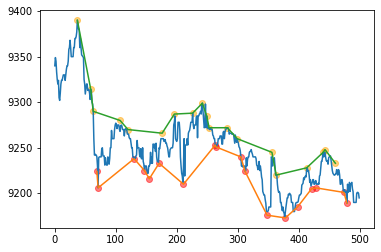

In [127]:
prices.reset_index()['Close'].plot()
plt.pyplot.scatter(maxima.index, maxima.values, color='orange', alpha=.5)
plt.pyplot.scatter(minima.index, minima.values, color='red', alpha=.5)

x = minima.index
y = minima.values
plt.pyplot.plot(x, y)

x = maxima.index
y = maxima.values
plt.pyplot.plot(x, y)

In [18]:
#initial
equity = 0
buy_point = 0
close_now = 0
exit_point = 0
earn = []
portion = 0
smoothing = 5
window = 10
target = 0

# maxima,minima = get_max_min(prices.iloc[:200, :], smoothing, window)

# uptrend_index = minima.index[-1]
# uptrend_price = minima.values[-1]
# minima_now_index = minima.index[-1]
# minima_now = minima.values[-1]

# downtrend_index = maxima.index[-1]
# downtrend_price = maxima.values[-1]
# maxima_now_index = maxima.index[-1]
# maxima_now = maxima.values[-1]

buy_x = []
buy_y = []
stop_x = []
stop_y = []
minima_index_list = []
minima_price_list = []
maxima_index_list = []
maxima_price_list = []

slope = 0

# n =200
test_prices = prices.iloc[200:300, :]

for i, close_now in enumerate(test_prices.Close.values):
    close_index = 100 + i
    # print(f'iter : {i}, portion : {portion}')
    # i start from 100
    maxima,minima = get_max_min(prices.iloc[100+i:200+i, :], smoothing, window)
    #随著時間進行index每次會減1
    maxima.index = maxima.index + i
    minima.index = minima.index + i
    # print(f'maxima list : {maxima}\n minima list : {minima}.')
    # print(f'close now [close_now] ; target price [target) ; slope (slope)')
    # print('trend stop')
    #入場條件
    if portion == 0:
        if target == 0:
            # 如果現有最高價已是下降趨勢，用來當趨勢線
            if maxima.values[-1] < maxima.values[-2]:
                maxima_now = maxima.values[-1]
                downtrend_price = maxima.values[-2]
                maxima_now_index = maxima.index[-1]
                downtrend_index = maxima.index[-2]
                slope = (maxima_now - downtrend_price)/(maxima_now_index - downtrend_index)
                assert slope < 0, 'slope > 0'
                if slope > -3:
                    slope = -3
            # 如果沒有趨勢，使用-3當作低標準
            else:
                maxima_now = maxima.values[-1]
                downtrend_price = maxima.values[-1]
                maxima_now_index = maxima.index[-1]
                downtrend_index = maxima.index[-1]
                slope = -3       
        else:
            if maxima.index[-1] > maxima_now_index:
                maxima_diff = maxima_now - maxima.values[-1]
                if maxima_diff > -20:
                    maxima_now = maxima.values[-1]
                    maxima_now_index = maxima.index[-1]
            slope = (maxima_now - downtrend_price)/(maxima_now_index - downtrend_index)
            assert slope < 0 , 'slope > 0'
            if slope > -3:
                slope = -3
        target = downtrend_price + (close_index - downtrend_index)*slope
        if close_now > target:
            portion = 1
            buy_point = close_now
            print(f'buy at {buy_point}')
            buy_x.append(i)
            buy_y.append(close_now)
            target = 0

    #出場條件
    if portion == 1:
        # 停損
        diff = close_now - buy_point
        if diff < -20:
            print(f'stop, sell at {close_now}, earn {diff}')
            earn.append(diff)
            portion = 0
            buy_point = 0
            stop_x.append(i)
            stop_y.append(close_now)
            target = 0
            # print('abs stop')
        if target == 0:
            # 如果現有最高價已是上降趨勢，用來當趨勢線
            if minima.values[-1] > minima.values[-2]:
                minima_now = minima.values[-1]
                uptrend_price = minima.values[-2]
                minima_now_index = minima.index[-1]
                uptrend_index = minima.index[-2]
                slope = (minima_now - uptrend_price)/(minima_now_index - uptrend_index)
                assert slope > 0, 'slope < 0'
                if slope < 3:
                    slope = 3
            # 如果沒有趨勢，使用3當作低標準
            else:
                minima_now = minima.values[-1]
                uptrend_price = minima.values[-1]
                minima_now_index = minima.index[-1]
                uptrend_index = minima.index[-1]
                slope = 3       
        else:
            if minima.index[-1] > minima_now_index:
                minima_diff = minima.values[-1] - minima_now
                if minima_diff > -20:
                    minima_now = minima.values[-1]
                    minima_now_index = minima.index[-1]         
            slope = (minima_now - uptrend_price)/(minima_now_index - uptrend_index)
            if slope < 3:
                slope = 3

        
        target = uptrend_price + (close_index - uptrend_index)*slope
        if close_now < target:
            print(f'earn, sell at {close_now}, earn {diff}')
            earn.append(diff)
            portion = 1
            buy_point = 0
            stop_x.append(i)
            stop_y.append(close_now)
            target = 0


buy at 9257.0
earn, sell at 9257.0, earn 0.0
earn, sell at 9260.0, earn 9260.0
earn, sell at 9278.0, earn 9278.0
earn, sell at 9278.0, earn 9278.0
earn, sell at 9278.0, earn 9278.0
earn, sell at 9269.0, earn 9269.0
earn, sell at 9240.0, earn 9240.0
earn, sell at 9230.0, earn 9230.0
earn, sell at 9222.0, earn 9222.0
earn, sell at 9219.0, earn 9219.0
earn, sell at 9212.0, earn 9212.0
earn, sell at 9230.0, earn 9230.0
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in double_scalars
earn, sell at 9288.0, earn 9288.0
earn, sell at 9290.0, earn 9290.0
earn, sell at 9287.0, earn 9287.0
earn, sell at 9298.0, earn 9298.0
earn, sell at 9299.0, earn 9299.0
earn, sell at 9290.0, earn 9290.0
earn, sell at 9280.0, earn 9280.0
earn, sell at 9272.0, earn 9272.0
earn, sell at 9273.0, earn 9273.0
earn, sell at 9298.0, earn 9298.0
earn, sell at 9272.0, earn 9272.0
earn, sell at 9285.0, earn 9285.0
earn, sell at 9275.0, earn 9275.

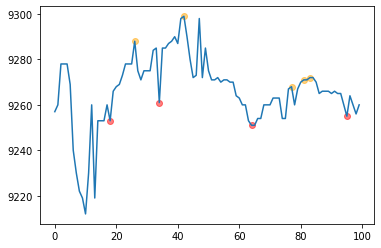

In [16]:
i = 0 
test_prices = prices.iloc[200+i:300+i, :]
smoothing = 5
window = 10 
maxima, minima = get_max_min(test_prices, smoothing, window)
test_prices.reset_index()['Close'].plot()
plt.pyplot.scatter(maxima.index, maxima.values, color='orange', alpha=.5)
plt.pyplot.scatter(minima.index, minima.values, color='red', alpha=.5)

In [12]:
a = 1
assert a > 0

In [135]:
accumu = 0
buy_point = 0
close_now = 0
exit_point = 0
earn = []
portion = 1
smoothing = 5
window = 20

maxima, minima = get_max_min(df.iloc[100+i:200+i, :], smoothing, window)

trend_index = []
trend_price = []
trend_index.append(minima.index[-1])
trend_price.append(minima.values[-1])

#initial
buy_point = prices.Close.values[0]
n = 200
for i, close in enumerate(prices.Close.values):
    diff = close - buy_point
    maxima, minima = get_max_min(df.iloc[n-100+i:n+i, :], smoothing, window)
    slope = (minima.values[-1] - trend_price[0])/( minima.index[-1] - trend_index[0] )
    if diff < -20:
        earn.append(diff)
        portion = 0
    
    if portion == 1:
        
        if minima.index[-1] != trend_index[0]:
            if minima.values[-1] > trend_price[0]:
                slope = (minima.values[-1] - trend_price[0])/( minima.index[-1] - trend_index[0] )
        target = minima.values[-1] + (n+i-minima.index[-1])*slope
        
        if close < target:
            diff = close - buy_point
            earn.append(diff)
            portion = 0
    
    if portion == 0:
        pass
        
        

C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [136]:
earn

[-35.0,
 -38.0,
 -30.0,
 -31.0,
 -25.0,
 -27.0,
 -26.0,
 -26.0,
 -30.0,
 -37.0,
 -26.0,
 -28.0,
 -40.0,
 -42.0,
 -50.0,
 -80.0,
 -98.0,
 -97.0,
 -98.0,
 -98.0,
 -100.0,
 -110.0,
 -134.0,
 -101.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -91.0,
 -90.0,
 -99.0,
 -99.0,
 -99.0,
 -109.0,
 -101.0,
 -108.0,
 -109.0,
 -109.0,
 -100.0,
 -102.0,
 -108.0,
 -102.0,
 -90.0,
 -90.0,
 -71.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -70.0,
 -65.0,
 -63.0,
 -65.0,
 -69.0,
 -65.0,
 -65.0,
 -65.0,
 -70.0,
 -72.0,
 -66.0,
 -65.0,
 -66.0,
 -70.0,
 -70.0,
 -70.0,
 -77.0,
 -70.0,
 -69.0,
 -70.0,
 -70.0,
 -75.0,
 -75.0,
 -75.0,
 -79.0,
 -80.0,
 -80.0,
 -85.0,
 -90.0,
 -90.0,
 -100.0,
 -100.0,
 -102.0,
 -101.0,
 -102.0,
 -99.0,
 -98.0,
 -82.0,
 -90.0,
 -90.0,
 -90.0,
 -98.0,
 -100.0,
 -91.0,
 -102.0,
 -102.0,
 -90.0,
 -105.0,
 -108.0,
 -115.0,
 -110.0,
 -110.0,
 -110.0,
 -115.0,
 -118.0,
 -118.0,
 -110.0,
 -110.0,
 -108.0,
 -95.0,
 -107.0,
 -100.0,
 -107.0,
 -86.0,
 -86.0,
 -90.0,
 -86.0,
 -94.0,
 -85.0,
 -100.0,
 -105.0

In [193]:
df['MA60'] = talib.SMA(df.Close, timeperiod=60)
df['MA20'] = talib.SMA(df.Close, timeperiod=20)

In [194]:
df['MACD'], df['MACDsignal'], macdhist = MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

In [195]:
df['Diff'] = df['Close'] - df['MA20']
df['MACD_Diff'] = df.MACD.diff()

In [196]:
# compute buy and sell signals (golden cross and death cross)
signal_long = (df.Diff > 0) & (df.MACD_Diff > 0)
signal_short = (df.MACD_Diff < 0)
# signal_long = (df.Close < df.MA20)
# signal_short = (df.Close > df.MA20)
# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

In [197]:
buy.tail()

4996    False
4997    False
4998     True
4999    False
5000    False
dtype: bool

In [198]:
close = df.Close
open_ = df.Open

### 計算買入時間

<AxesSubplot:>

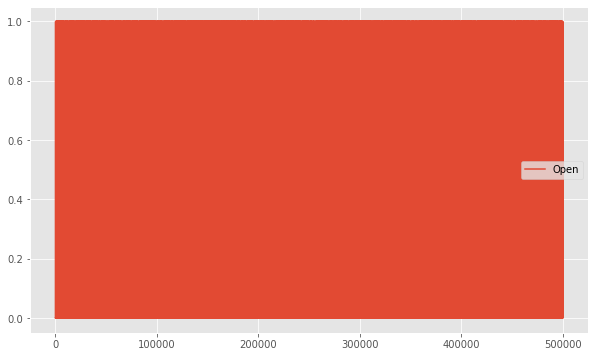

In [199]:
buy = (signal > 0)
sell = close < close.rolling(20).mean()
    
hold = pd.DataFrame(np.nan, index=close.index, columns=['Open'])
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.fillna(0, inplace=True)
hold = hold.shift()

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
hold.plot()

### 計算報酬率

In [200]:
import matplotlib.pyplot as plt

gain = (open_.shift(-1).ffill() / open_.ffill()).to_frame()

In [201]:
eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()
# eq = gain[hold == 1]

<AxesSubplot:>

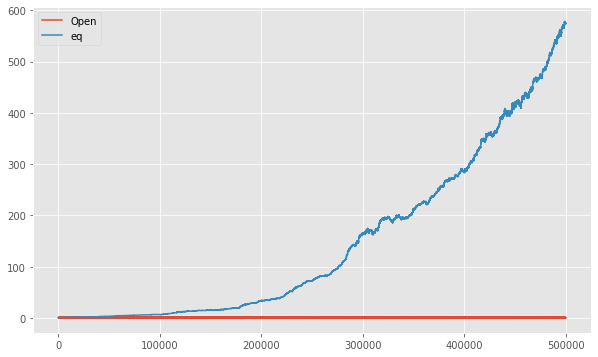

In [202]:
draw_df = hold.copy()
draw_df['eq'] = eq

draw_df.plot()

### 不要每天都rebalance

2.3126964791497087

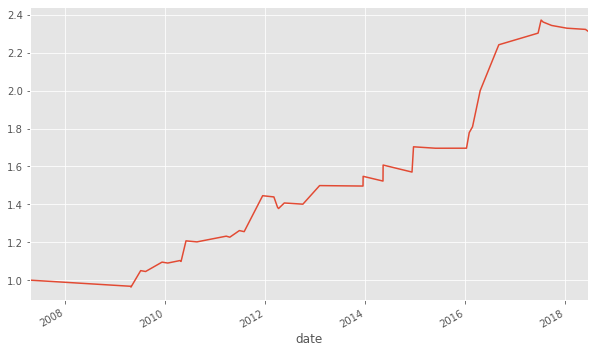

In [5]:
rebalance = (hold.diff().abs().sum(axis=1) != 0).cumsum()
rebalance_hold = hold[rebalance.diff() != 0]
rebalance_gain = gain.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1])
rebalance_gain.index = rebalance_hold.index

# 手續費
position_diff = rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).fillna(0).diff()
tax_ratio = position_diff.copy()
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
tax_ratio = tax_ratio.abs().sum(axis=1)


eq2 = (rebalance_gain[rebalance_hold == 1].mean(axis=1).fillna(1) * (1 - tax_ratio)).cumprod()
eq2.plot()
eq2.iloc[-1]

## 考慮手續費

In [7]:
import pickle
pickle.dump(eq, open('return_history.pkl', 'wb'))